In [2]:
# ML / AI / Vision
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset


# Visual
import matplotlib.pyplot as plt

# General
import time
import random
import datetime
from typing import Tuple, List, Dict, Any, Union, Optional, Callable

torchvision.__version__, torch.__version__

('0.15.2+cu117', '2.0.1+cu117')

In [3]:
MURA_PATH = "MURA-v1.1/"

# Load the data
train_df = pd.read_csv(MURA_PATH + "train_image_paths.csv", names=['path'])
valid_df = pd.read_csv(MURA_PATH + "valid_image_paths.csv", names=['path'])

train_df.shape, valid_df.shape

((36808, 1), (3197, 1))

In [4]:
train_df

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


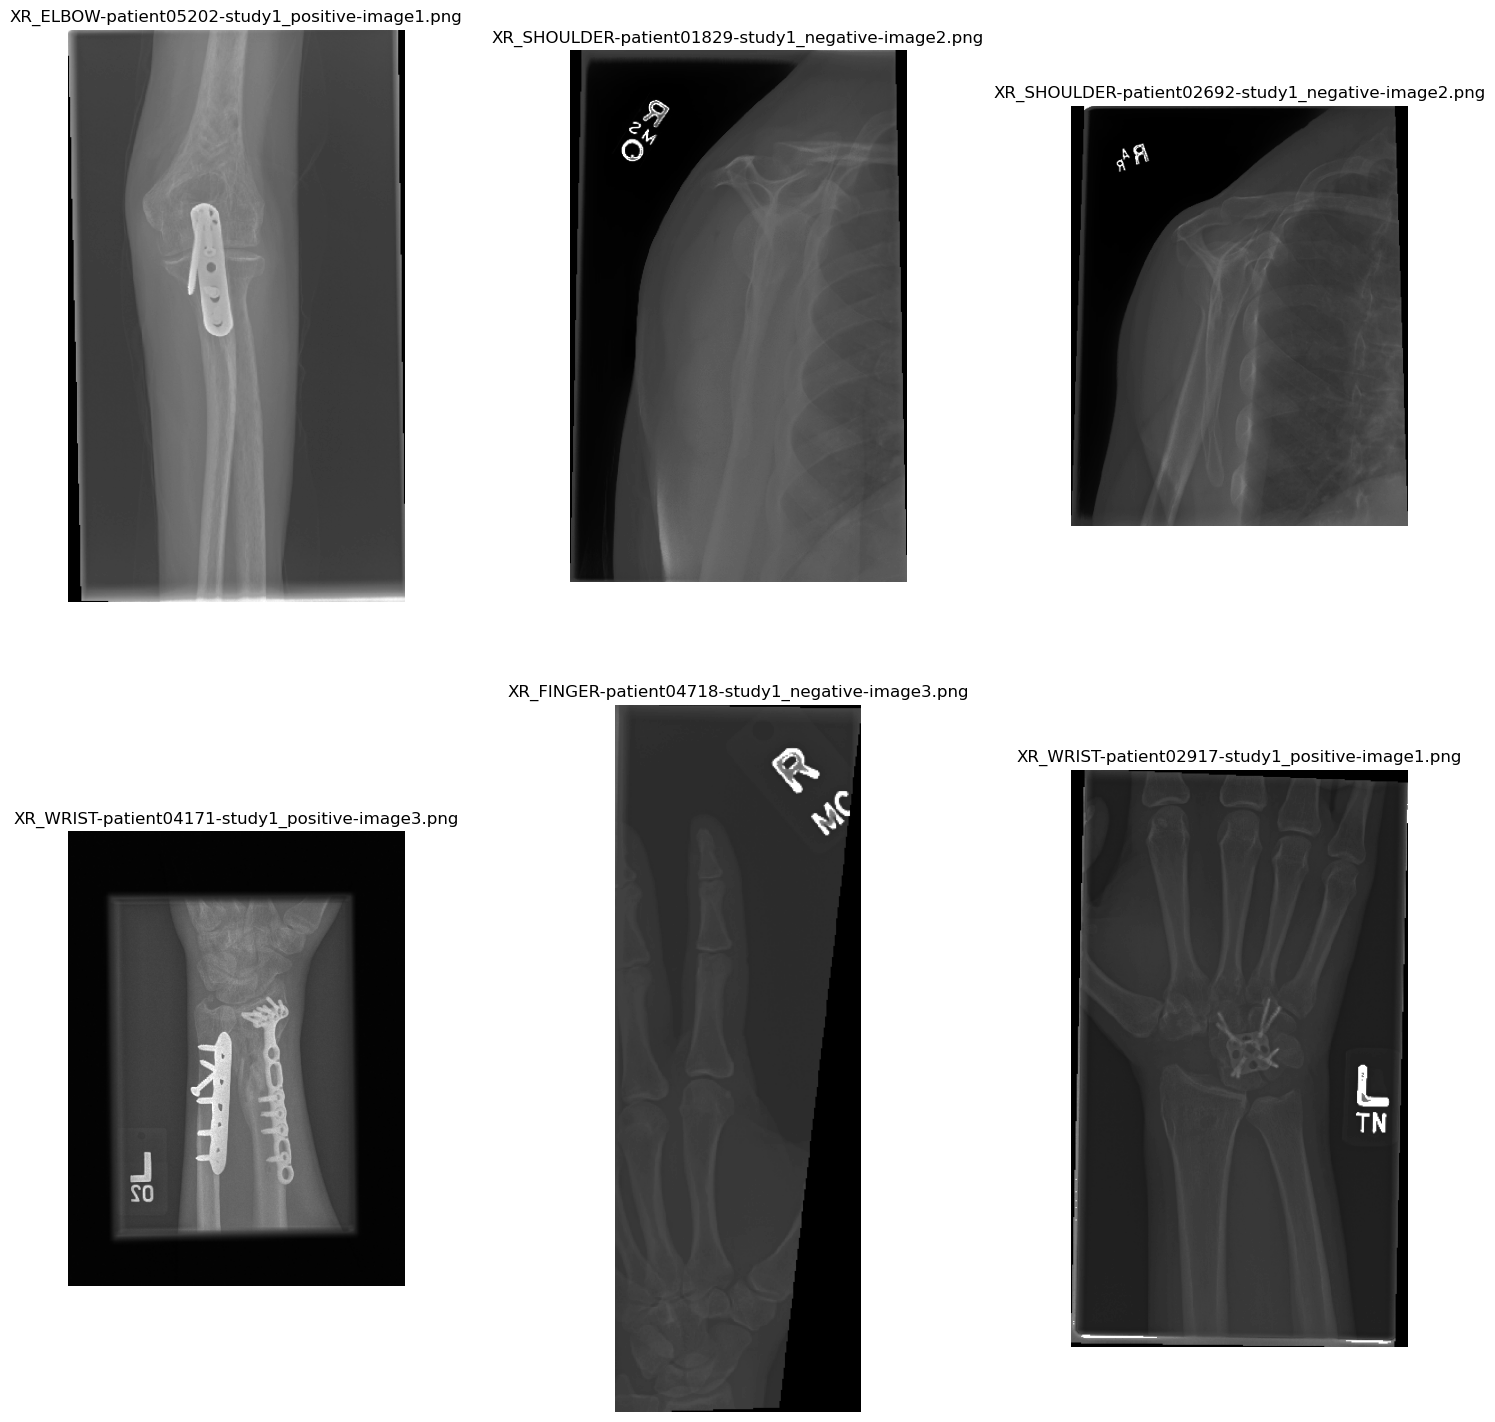

In [5]:
w, h = 10, 10
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
start, end = 0, train_df.shape[0]

for ax in axes.flatten():
    k = random.randint(start, end - 1)
    img = mpimg.imread(train_df.iloc[k, 0])
    title = "-".join(train_df.iloc[k, 0].split('/')[2:])
    
    ax.set_title(title)
    ax.axis('off')
    ax.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [6]:
train_df['Label'] = train_df.apply(lambda x:1 if 'positive' in x.path else 0, axis=1)
train_df['BodyPart'] = train_df.apply(lambda x: x.path.split('/')[2][3:],axis=1)
train_df['StudyType'] = train_df.apply(lambda x: x.path.split('/')[4][:6],axis=1)

valid_df['Label'] = valid_df.apply(lambda x:1 if 'positive' in x.path else 0, axis=1)
valid_df['BodyPart'] = valid_df.apply(lambda x: x.path.split('/')[2][3:],axis=1)
valid_df['StudyType'] = valid_df.apply(lambda x: x.path.split('/')[4][:6],axis=1)
train_df.set_index(["path", "BodyPart"]).count(level="BodyPart")

train_df.set_index(["path", "Label"]).count(level="Label")

/tmp/ipykernel_3113/1941283575.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.count(level=1) should use df.groupby(level=1).count().
  train_df.set_index(["path", "BodyPart"]).count(level="BodyPart")
/tmp/ipykernel_3113/1941283575.py:10: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.count(level=1) should use df.groupby(level=1).count().
  train_df.set_index(["path", "Label"]).count(level="Label")


,BodyPart,StudyType
Label,,
0,21935,21935
1,14873,14873


In [7]:
# Use only the Hand, shoulder and elbow
train_df = train_df[train_df['BodyPart'].isin(['HAND', 'SHOULDER', 'ELBOW'])]
valid_df = valid_df[valid_df['BodyPart'].isin(['HAND', 'SHOULDER', 'ELBOW'])]

train_df.shape, valid_df.shape


((18853, 4), (1488, 4))

In [8]:
from PIL import Image

class MuraDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]

        img = Image.open(img_name).convert("RGB")
        #img = mpimg.imread(img_name)

        if self.transform:
            img = self.transform(img).type(torch.FloatTensor)

        label = torch.from_numpy(np.asarray(label)).double().type(torch.FloatTensor)
        return img, label
    
    def get_labels_weights(self):
        total_count = len(self.df)
        positive_count = len(self.df[self.df['Label'] == 1])
        negative_count = len(self.df[self.df['Label'] == 0])

        positive_weight = positive_count / total_count
        negative_weight = negative_count / total_count

        return [negative_weight, positive_weight]

    
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
# We resize the images to 224x224 and normalize them with the mean and std of the ImageNet dataset.
# In the training set, we also apply random horizontal flip and random rotation of 10 degrees.
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Normalize([0.456], [0.224]),
    ]
)
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.Normalize([0.456], [0.224]),
    ]
)

train_dataset = MuraDataset(df=train_df, transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_dataset = MuraDataset(df=valid_df, transform=val_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=True)

print(train_dataset.get_labels_weights())
print(val_dataset.get_labels_weights())

[0.5938046995173182, 0.4061953004826818]
[0.5315860215053764, 0.46841397849462363]


In [10]:
def format_time(elapsed):
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# Metric
def accuracy(y_true, y_pred):
    y_pred = torch.round(y_pred)
    return (y_true == y_pred).float().mean()

In [11]:

def train_epoch(model, train_loader, loss_fn, optimizer):
    t0 = time.time()
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for batch_num, (images, labels) in enumerate(train_loader):
        if batch_num % 100 == 0 and not batch_num == 0:
            # Calculate elapsed time.
            elapsed = format_time(time.time() - t0)
            print(
                f"  Batch {batch_num:>5,}/{len(train_loader):>5,}.    Elapsed: {elapsed}."
            )

        # Send data to GPU
        images = torch.stack([image.cuda() for image in images])
        labels = torch.vstack([label.cuda() for label in labels])

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        # Calculate loss & accuracy
        loss = loss_fn(outputs, labels)
        acc = accuracy(labels, outputs)

        # Backward pass & Update weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
        running_acc += acc.item()

    return running_loss / len(train_loader), running_acc / len(train_loader)


def validate(model, val_loader, loss_fn):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = torch.stack([image.cuda() for image in images])
            targets = torch.vstack([label.cuda() for label in labels])

            outputs = model(images)
            
            loss = loss_fn(outputs, targets)
            acc = accuracy(targets, outputs)
            
            running_loss += loss.item()
            running_acc += acc.item() 

    return running_loss / len(val_loader), running_acc / len(val_loader)


def train_model(model, train_loader, val_loader, loss_fn, optimizer, n_epochs=10):
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_acc_list = []
    val_acc_list = []

    # We add a learning rate scheduler which decreases the learning rate by a factor of 10
    # each time the validation loss plateaus after one epoch.
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=1, verbose=True
    )

    for epoch in range(n_epochs):
        print(f"======== Epoch {epoch + 1} / {n_epochs} ========")

        start = time.time()
        print(f"Training on training dataset...")
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)

        # Evaluate on validation dataset
        print(f"Evaluate on validation dataset...")
        val_loss, val_acc = validate(model, val_loader, loss_fn)

        # Update the learning rate.
        lr_scheduler.step(val_loss)

        if val_acc > best_acc:
            best_acc = val_acc
            print(f"Save model with best accuracy: {best_acc:.4f}")
            torch.save(model.state_dict(), "baseline_model.pt")

        print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
        print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")
        print(f"Epoch took: {format_time(time.time() - start)}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

    return train_losses, val_losses, train_acc_list, val_acc_list

In [ ]:
# Model
# model = torchvision.models.resnet50(weights="ResNet50_Weights.DEFAULT")
model = torchvision.models.densenet169(weights="DenseNet169_Weights.DEFAULT")
model.classifier = torch.nn.Linear(model.classifier.in_features, 1)
model = model.cuda()

# The network was trained end-to-end using Adam with default parameters β1 = 0.9 and β2 = 0.999
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=0.0001)




# loss_fn = torch.nn.BCELoss()

train_losses, val_losses, train_acc, val_acc = train_model(
    model, train_loader, val_loader, loss_fn, optimizer, n_epochs=5
)

In [ ]:

# Load the best model
model.load_state_dict(torch.load("baseline_model.pt"))

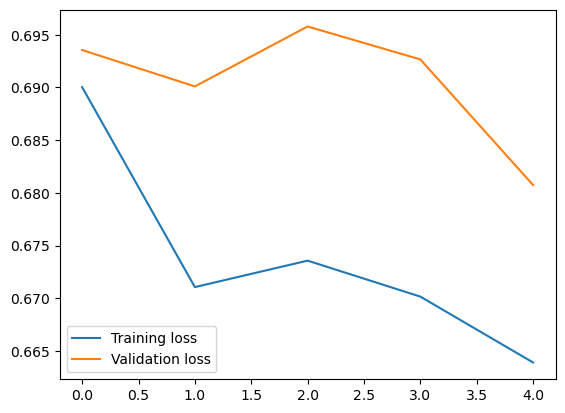

In [34]:
# Plot the training and validation loss
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()


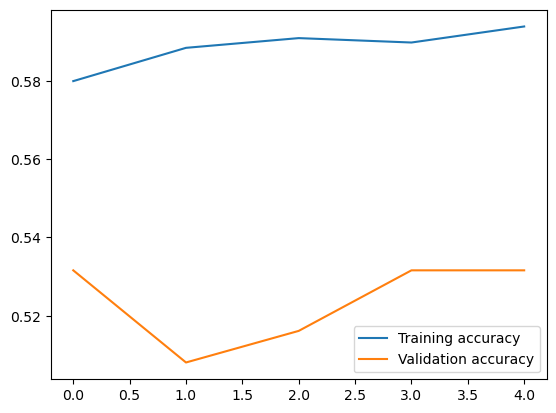

In [35]:
# Plot the training and validation accuracy
plt.plot(train_acc, label="Training accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.legend()
plt.show()


Hyperparameter tuning

In [12]:
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [8, 16, 32]

results = []
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Learning rate: {lr}, Batch size: {bs}")
        model = torchvision.models.densenet169(weights="DenseNet169_Weights.DEFAULT")
        model.classifier = torch.nn.Linear(model.classifier.in_features, 1)
        model = model.cuda()

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4)

        # Adam optimizer
        optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=lr)

        # Loss - weighted Binary Cross Entropy
        positive_weight = torch.FloatTensor([train_dataset.get_labels_weights()[1]])
        loss_fn = torch.nn.BCEWithLogitsLoss()

        train_losses, val_losses, train_acc_list, val_acc_list = train_model(model, train_loader, val_loader, loss_fn, optimizer, n_epochs=5)
        
        results.append({
            'lr': lr,
            'batch_size': bs,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_acc': train_acc_list,
            'val_acc': val_acc_list
        })
        
        print("=====================================================")

# Write to json
with open("results.json", "w") as f:
    json.dump(results, f)



Learning rate: 0.01, Batch size: 8
======== Epoch 1 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:24.
  Batch   200/2,357.    Elapsed: 0:00:34.
  Batch   300/2,357.    Elapsed: 0:00:45.
  Batch   400/2,357.    Elapsed: 0:00:55.
  Batch   500/2,357.    Elapsed: 0:01:06.
  Batch   600/2,357.    Elapsed: 0:01:16.
  Batch   700/2,357.    Elapsed: 0:01:26.
  Batch   800/2,357.    Elapsed: 0:01:36.
  Batch   900/2,357.    Elapsed: 0:01:47.
  Batch 1,000/2,357.    Elapsed: 0:01:57.
  Batch 1,100/2,357.    Elapsed: 0:02:07.
  Batch 1,200/2,357.    Elapsed: 0:02:17.
  Batch 1,300/2,357.    Elapsed: 0:02:28.
  Batch 1,400/2,357.    Elapsed: 0:02:38.
  Batch 1,500/2,357.    Elapsed: 0:02:48.
  Batch 1,600/2,357.    Elapsed: 0:02:59.
  Batch 1,700/2,357.    Elapsed: 0:03:09.
  Batch 1,800/2,357.    Elapsed: 0:03:20.
  Batch 1,900/2,357.    Elapsed: 0:03:30.
  Batch 2,000/2,357.    Elapsed: 0:03:40.
  Batch 2,100/2,357.    Elapsed: 0:03:50.
  Batch 2,200/2,357.    Elapsed: 0:04:01.
  Batch 2,300/2,357.    Elapsed: 0:04:11.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.4462
Train loss: 0.6855, Train accuracy: 0.3982
Validation loss: 0.6899, Validation accuracy: 0.4462
Epoch took: 0:04:24
======== Epoch 2 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:10.
  Batch   200/2,357.    Elapsed: 0:00:20.
  Batch   300/2,357.    Elapsed: 0:00:31.
  Batch   400/2,357.    Elapsed: 0:00:41.
  Batch   500/2,357.    Elapsed: 0:00:51.
  Batch   600/2,357.    Elapsed: 0:01:01.
  Batch   700/2,357.    Elapsed: 0:01:11.
  Batch   800/2,357.    Elapsed: 0:01:21.
  Batch   900/2,357.    Elapsed: 0:01:31.
  Batch 1,000/2,357.    Elapsed: 0:01:42.
  Batch 1,100/2,357.    Elapsed: 0:01:52.
  Batch 1,200/2,357.    Elapsed: 0:02:02.
  Batch 1,300/2,357.    Elapsed: 0:02:12.
  Batch 1,400/2,357.    Elapsed: 0:02:22.
  Batch 1,500/2,357.    Elapsed: 0:02:32.
  Batch 1,600/2,357.    Elapsed: 0:02:42.
  Batch 1,700/2,357.    Elapsed: 0:02:52.
  Batch 1,800/2,357.    Elapsed: 0:03:02.
  Batch 1,900/2,357.    Elapsed: 0:03:13.
  Batch 2,000/2,357.    Elapsed: 0:03:23.
  Batch 2,100/2,357.    Elapsed: 0:03:33.
  Batch 2,200/2,357.    Elapsed: 0:03:43.
  Batch 2,300/2,357.    Elapsed: 0:03:53.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6744, Train accuracy: 0.4057
Validation loss: 0.7626, Validation accuracy: 0.1136
Epoch took: 0:04:05
======== Epoch 3 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:10.
  Batch   200/2,357.    Elapsed: 0:00:21.
  Batch   300/2,357.    Elapsed: 0:00:31.
  Batch   400/2,357.    Elapsed: 0:00:41.
  Batch   500/2,357.    Elapsed: 0:00:51.
  Batch   600/2,357.    Elapsed: 0:01:01.
  Batch   700/2,357.    Elapsed: 0:01:11.
  Batch   800/2,357.    Elapsed: 0:01:22.
  Batch   900/2,357.    Elapsed: 0:01:32.
  Batch 1,000/2,357.    Elapsed: 0:01:42.
  Batch 1,100/2,357.    Elapsed: 0:01:52.
  Batch 1,200/2,357.    Elapsed: 0:02:02.
  Batch 1,300/2,357.    Elapsed: 0:02:12.
  Batch 1,400/2,357.    Elapsed: 0:02:23.
  Batch 1,500/2,357.    Elapsed: 0:02:33.
  Batch 1,600/2,357.    Elapsed: 0:02:43.
  Batch 1,700/2,357.    Elapsed: 0:02:53.
  Batch 1,800/2,357.    Elapsed: 0:03:03.
  Batch 1,900/2,357.    Elapsed: 0:03:13.
  Batch 2,000/2,357.    Elapsed: 0:03:24.
  Batch 2,100/2,357.    Elapsed: 0:03:34.
  Batch 2,200/2,357.    Elapsed: 0:03:44.
  Batch 2,300/2,357.    Elapsed: 0:03:54.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Epoch 00003: reducing learning rate of group 0 to 1.0000e-03.
Train loss: 0.6711, Train accuracy: 0.4003
Validation loss: 0.6938, Validation accuracy: 0.3333
Epoch took: 0:04:06
======== Epoch 4 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:10.
  Batch   200/2,357.    Elapsed: 0:00:20.
  Batch   300/2,357.    Elapsed: 0:00:31.
  Batch   400/2,357.    Elapsed: 0:00:41.
  Batch   500/2,357.    Elapsed: 0:00:51.
  Batch   600/2,357.    Elapsed: 0:01:01.
  Batch   700/2,357.    Elapsed: 0:01:11.
  Batch   800/2,357.    Elapsed: 0:01:21.
  Batch   900/2,357.    Elapsed: 0:01:31.
  Batch 1,000/2,357.    Elapsed: 0:01:42.
  Batch 1,100/2,357.    Elapsed: 0:01:52.
  Batch 1,200/2,357.    Elapsed: 0:02:02.
  Batch 1,300/2,357.    Elapsed: 0:02:12.
  Batch 1,400/2,357.    Elapsed: 0:02:22.
  Batch 1,500/2,357.    Elapsed: 0:02:32.
  Batch 1,600/2,357.    Elapsed: 0:02:43.
  Batch 1,700/2,357.    Elapsed: 0:02:53.
  Batch 1,800/2,357.    Elapsed: 0:03:03.
  Batch 1,900/2,357.    Elapsed: 0:03:13.
  Batch 2,000/2,357.    Elapsed: 0:03:23.
  Batch 2,100/2,357.    Elapsed: 0:03:33.
  Batch 2,200/2,357.    Elapsed: 0:03:43.
  Batch 2,300/2,357.    Elapsed: 0:03:54.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6636, Train accuracy: 0.3601
Validation loss: 0.6869, Validation accuracy: 0.3831
Epoch took: 0:04:05
======== Epoch 5 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:21.
  Batch   300/2,357.    Elapsed: 0:00:31.
  Batch   400/2,357.    Elapsed: 0:00:41.
  Batch   500/2,357.    Elapsed: 0:00:51.
  Batch   600/2,357.    Elapsed: 0:01:01.
  Batch   700/2,357.    Elapsed: 0:01:11.
  Batch   800/2,357.    Elapsed: 0:01:21.
  Batch   900/2,357.    Elapsed: 0:01:32.
  Batch 1,000/2,357.    Elapsed: 0:01:42.
  Batch 1,100/2,357.    Elapsed: 0:01:52.
  Batch 1,200/2,357.    Elapsed: 0:02:02.
  Batch 1,300/2,357.    Elapsed: 0:02:12.
  Batch 1,400/2,357.    Elapsed: 0:02:23.
  Batch 1,500/2,357.    Elapsed: 0:02:33.
  Batch 1,600/2,357.    Elapsed: 0:02:43.
  Batch 1,700/2,357.    Elapsed: 0:02:53.
  Batch 1,800/2,357.    Elapsed: 0:03:03.
  Batch 1,900/2,357.    Elapsed: 0:03:13.
  Batch 2,000/2,357.    Elapsed: 0:03:23.
  Batch 2,100/2,357.    Elapsed: 0:03:34.
  Batch 2,200/2,357.    Elapsed: 0:03:44.
  Batch 2,300/2,357.    Elapsed: 0:03:54.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6589, Train accuracy: 0.3483
Validation loss: 0.6899, Validation accuracy: 0.3421
Epoch took: 0:04:06
Learning rate: 0.01, Batch size: 16
======== Epoch 1 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:35.
  Batch   400/1,179.    Elapsed: 0:00:46.
  Batch   500/1,179.    Elapsed: 0:00:58.
  Batch   600/1,179.    Elapsed: 0:01:09.
  Batch   700/1,179.    Elapsed: 0:01:21.
  Batch   800/1,179.    Elapsed: 0:01:32.
  Batch   900/1,179.    Elapsed: 0:01:44.
  Batch 1,000/1,179.    Elapsed: 0:01:55.
  Batch 1,100/1,179.    Elapsed: 0:02:07.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.2997
Train loss: 0.6998, Train accuracy: 0.3649
Validation loss: 0.7285, Validation accuracy: 0.2997
Epoch took: 0:02:20
======== Epoch 2 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:35.
  Batch   400/1,179.    Elapsed: 0:00:47.
  Batch   500/1,179.    Elapsed: 0:00:58.
  Batch   600/1,179.    Elapsed: 0:01:10.
  Batch   700/1,179.    Elapsed: 0:01:21.
  Batch   800/1,179.    Elapsed: 0:01:33.
  Batch   900/1,179.    Elapsed: 0:01:45.
  Batch 1,000/1,179.    Elapsed: 0:01:56.
  Batch 1,100/1,179.    Elapsed: 0:02:08.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6691, Train accuracy: 0.3864
Validation loss: 0.7023, Validation accuracy: 0.2587
Epoch took: 0:02:21
======== Epoch 3 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:23.
  Batch   300/1,179.    Elapsed: 0:00:35.
  Batch   400/1,179.    Elapsed: 0:00:47.
  Batch   500/1,179.    Elapsed: 0:00:58.
  Batch   600/1,179.    Elapsed: 0:01:10.
  Batch   700/1,179.    Elapsed: 0:01:21.
  Batch   800/1,179.    Elapsed: 0:01:33.
  Batch   900/1,179.    Elapsed: 0:01:44.
  Batch 1,000/1,179.    Elapsed: 0:01:56.
  Batch 1,100/1,179.    Elapsed: 0:02:07.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.4328
Train loss: 0.6710, Train accuracy: 0.3979
Validation loss: 0.8193, Validation accuracy: 0.4328
Epoch took: 0:02:21
======== Epoch 4 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:35.
  Batch   400/1,179.    Elapsed: 0:00:47.
  Batch   500/1,179.    Elapsed: 0:00:58.
  Batch   600/1,179.    Elapsed: 0:01:10.
  Batch   700/1,179.    Elapsed: 0:01:21.
  Batch   800/1,179.    Elapsed: 0:01:33.
  Batch   900/1,179.    Elapsed: 0:01:45.
  Batch 1,000/1,179.    Elapsed: 0:01:56.
  Batch 1,100/1,179.    Elapsed: 0:02:08.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6701, Train accuracy: 0.3759
Validation loss: 0.6973, Validation accuracy: 0.2789
Epoch took: 0:02:21
======== Epoch 5 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:23.
  Batch   300/1,179.    Elapsed: 0:00:35.
  Batch   400/1,179.    Elapsed: 0:00:47.
  Batch   500/1,179.    Elapsed: 0:00:58.
  Batch   600/1,179.    Elapsed: 0:01:10.
  Batch   700/1,179.    Elapsed: 0:01:21.
  Batch   800/1,179.    Elapsed: 0:01:33.
  Batch   900/1,179.    Elapsed: 0:01:44.
  Batch 1,000/1,179.    Elapsed: 0:01:56.
  Batch 1,100/1,179.    Elapsed: 0:02:07.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.4819
Train loss: 0.6647, Train accuracy: 0.3518
Validation loss: 0.8240, Validation accuracy: 0.4819
Epoch took: 0:02:21
Learning rate: 0.01, Batch size: 32
======== Epoch 1 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:00.
  Batch   500/  590.    Elapsed: 0:01:16.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.4854
Train loss: 0.6948, Train accuracy: 0.3714
Validation loss: 0.7161, Validation accuracy: 0.4854
Epoch took: 0:01:33
======== Epoch 2 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:45.
  Batch   400/  590.    Elapsed: 0:01:00.
  Batch   500/  590.    Elapsed: 0:01:15.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6638, Train accuracy: 0.3554
Validation loss: 0.6970, Validation accuracy: 0.3391
Epoch took: 0:01:32
======== Epoch 3 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:01.
  Batch   500/  590.    Elapsed: 0:01:16.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6601, Train accuracy: 0.3484
Validation loss: 0.6895, Validation accuracy: 0.2786
Epoch took: 0:01:32
======== Epoch 4 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:30.
  Batch   300/  590.    Elapsed: 0:00:45.
  Batch   400/  590.    Elapsed: 0:01:00.
  Batch   500/  590.    Elapsed: 0:01:15.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6627, Train accuracy: 0.3549
Validation loss: 0.7418, Validation accuracy: 0.3544
Epoch took: 0:01:32
======== Epoch 5 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:01.
  Batch   500/  590.    Elapsed: 0:01:16.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Epoch 00005: reducing learning rate of group 0 to 1.0000e-03.
Train loss: 0.6581, Train accuracy: 0.3454
Validation loss: 0.6898, Validation accuracy: 0.3790
Epoch took: 0:01:33
Learning rate: 0.001, Batch size: 8
======== Epoch 1 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:21.
  Batch   300/2,357.    Elapsed: 0:00:32.
  Batch   400/2,357.    Elapsed: 0:00:42.
  Batch   500/2,357.    Elapsed: 0:00:52.
  Batch   600/2,357.    Elapsed: 0:01:03.
  Batch   700/2,357.    Elapsed: 0:01:13.
  Batch   800/2,357.    Elapsed: 0:01:24.
  Batch   900/2,357.    Elapsed: 0:01:34.
  Batch 1,000/2,357.    Elapsed: 0:01:44.
  Batch 1,100/2,357.    Elapsed: 0:01:55.
  Batch 1,200/2,357.    Elapsed: 0:02:05.
  Batch 1,300/2,357.    Elapsed: 0:02:16.
  Batch 1,400/2,357.    Elapsed: 0:02:26.
  Batch 1,500/2,357.    Elapsed: 0:02:36.
  Batch 1,600/2,357.    Elapsed: 0:02:47.
  Batch 1,700/2,357.    Elapsed: 0:02:57.
  Batch 1,800/2,357.    Elapsed: 0:03:08.
  Batch 1,900/2,357.    Elapsed: 0:03:18.
  Batch 2,000/2,357.    Elapsed: 0:03:29.
  Batch 2,100/2,357.    Elapsed: 0:03:39.
  Batch 2,200/2,357.    Elapsed: 0:03:49.
  Batch 2,300/2,357.    Elapsed: 0:04:00.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.3300
Train loss: 0.6886, Train accuracy: 0.3551
Validation loss: 2.3755, Validation accuracy: 0.3300
Epoch took: 0:04:13
======== Epoch 2 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:21.
  Batch   300/2,357.    Elapsed: 0:00:31.
  Batch   400/2,357.    Elapsed: 0:00:42.
  Batch   500/2,357.    Elapsed: 0:00:52.
  Batch   600/2,357.    Elapsed: 0:01:03.
  Batch   700/2,357.    Elapsed: 0:01:13.
  Batch   800/2,357.    Elapsed: 0:01:24.
  Batch   900/2,357.    Elapsed: 0:01:34.
  Batch 1,000/2,357.    Elapsed: 0:01:44.
  Batch 1,100/2,357.    Elapsed: 0:01:55.
  Batch 1,200/2,357.    Elapsed: 0:02:05.
  Batch 1,300/2,357.    Elapsed: 0:02:16.
  Batch 1,400/2,357.    Elapsed: 0:02:26.
  Batch 1,500/2,357.    Elapsed: 0:02:37.
  Batch 1,600/2,357.    Elapsed: 0:02:47.
  Batch 1,700/2,357.    Elapsed: 0:02:58.
  Batch 1,800/2,357.    Elapsed: 0:03:08.
  Batch 1,900/2,357.    Elapsed: 0:03:19.
  Batch 2,000/2,357.    Elapsed: 0:03:29.
  Batch 2,100/2,357.    Elapsed: 0:03:39.
  Batch 2,200/2,357.    Elapsed: 0:03:50.
  Batch 2,300/2,357.    Elapsed: 0:04:00.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6744, Train accuracy: 0.3624
Validation loss: 42.0328, Validation accuracy: 0.2944
Epoch took: 0:04:12
======== Epoch 3 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:21.
  Batch   300/2,357.    Elapsed: 0:00:32.
  Batch   400/2,357.    Elapsed: 0:00:42.
  Batch   500/2,357.    Elapsed: 0:00:53.
  Batch   600/2,357.    Elapsed: 0:01:03.
  Batch   700/2,357.    Elapsed: 0:01:14.
  Batch   800/2,357.    Elapsed: 0:01:24.
  Batch   900/2,357.    Elapsed: 0:01:34.
  Batch 1,000/2,357.    Elapsed: 0:01:45.
  Batch 1,100/2,357.    Elapsed: 0:01:55.
  Batch 1,200/2,357.    Elapsed: 0:02:06.
  Batch 1,300/2,357.    Elapsed: 0:02:16.
  Batch 1,400/2,357.    Elapsed: 0:02:27.
  Batch 1,500/2,357.    Elapsed: 0:02:37.
  Batch 1,600/2,357.    Elapsed: 0:02:47.
  Batch 1,700/2,357.    Elapsed: 0:02:58.
  Batch 1,800/2,357.    Elapsed: 0:03:08.
  Batch 1,900/2,357.    Elapsed: 0:03:19.
  Batch 2,000/2,357.    Elapsed: 0:03:29.
  Batch 2,100/2,357.    Elapsed: 0:03:39.
  Batch 2,200/2,357.    Elapsed: 0:03:50.
  Batch 2,300/2,357.    Elapsed: 0:04:00.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6750, Train accuracy: 0.4078
Validation loss: 0.7162, Validation accuracy: 0.2728
Epoch took: 0:04:12
======== Epoch 4 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:21.
  Batch   300/2,357.    Elapsed: 0:00:32.
  Batch   400/2,357.    Elapsed: 0:00:42.
  Batch   500/2,357.    Elapsed: 0:00:53.
  Batch   600/2,357.    Elapsed: 0:01:03.
  Batch   700/2,357.    Elapsed: 0:01:14.
  Batch   800/2,357.    Elapsed: 0:01:25.
  Batch   900/2,357.    Elapsed: 0:01:35.
  Batch 1,000/2,357.    Elapsed: 0:01:46.
  Batch 1,100/2,357.    Elapsed: 0:01:57.
  Batch 1,200/2,357.    Elapsed: 0:02:07.
  Batch 1,300/2,357.    Elapsed: 0:02:18.
  Batch 1,400/2,357.    Elapsed: 0:02:28.
  Batch 1,500/2,357.    Elapsed: 0:02:39.
  Batch 1,600/2,357.    Elapsed: 0:02:50.
  Batch 1,700/2,357.    Elapsed: 0:03:00.
  Batch 1,800/2,357.    Elapsed: 0:03:11.
  Batch 1,900/2,357.    Elapsed: 0:03:21.
  Batch 2,000/2,357.    Elapsed: 0:03:32.
  Batch 2,100/2,357.    Elapsed: 0:03:42.
  Batch 2,200/2,357.    Elapsed: 0:03:53.
  Batch 2,300/2,357.    Elapsed: 0:04:04.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6695, Train accuracy: 0.3813
Validation loss: 0.6883, Validation accuracy: 0.3280
Epoch took: 0:04:16
======== Epoch 5 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:22.
  Batch   300/2,357.    Elapsed: 0:00:32.
  Batch   400/2,357.    Elapsed: 0:00:43.
  Batch   500/2,357.    Elapsed: 0:00:53.
  Batch   600/2,357.    Elapsed: 0:01:04.
  Batch   700/2,357.    Elapsed: 0:01:15.
  Batch   800/2,357.    Elapsed: 0:01:25.
  Batch   900/2,357.    Elapsed: 0:01:36.
  Batch 1,000/2,357.    Elapsed: 0:01:46.
  Batch 1,100/2,357.    Elapsed: 0:01:57.
  Batch 1,200/2,357.    Elapsed: 0:02:08.
  Batch 1,300/2,357.    Elapsed: 0:02:18.
  Batch 1,400/2,357.    Elapsed: 0:02:29.
  Batch 1,500/2,357.    Elapsed: 0:02:39.
  Batch 1,600/2,357.    Elapsed: 0:02:50.
  Batch 1,700/2,357.    Elapsed: 0:03:01.
  Batch 1,800/2,357.    Elapsed: 0:03:11.
  Batch 1,900/2,357.    Elapsed: 0:03:22.
  Batch 2,000/2,357.    Elapsed: 0:03:33.
  Batch 2,100/2,357.    Elapsed: 0:03:43.
  Batch 2,200/2,357.    Elapsed: 0:03:54.
  Batch 2,300/2,357.    Elapsed: 0:04:05.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.4301
Train loss: 0.6669, Train accuracy: 0.3660
Validation loss: 0.6950, Validation accuracy: 0.4301
Epoch took: 0:04:17
Learning rate: 0.001, Batch size: 16
======== Epoch 1 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:36.
  Batch   400/1,179.    Elapsed: 0:00:48.
  Batch   500/1,179.    Elapsed: 0:01:00.
  Batch   600/1,179.    Elapsed: 0:01:12.
  Batch   700/1,179.    Elapsed: 0:01:23.
  Batch   800/1,179.    Elapsed: 0:01:35.
  Batch   900/1,179.    Elapsed: 0:01:47.
  Batch 1,000/1,179.    Elapsed: 0:01:59.
  Batch 1,100/1,179.    Elapsed: 0:02:11.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.3132
Train loss: 0.6798, Train accuracy: 0.3604
Validation loss: 0.7028, Validation accuracy: 0.3132
Epoch took: 0:02:24
======== Epoch 2 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:36.
  Batch   400/1,179.    Elapsed: 0:00:48.
  Batch   500/1,179.    Elapsed: 0:01:00.
  Batch   600/1,179.    Elapsed: 0:01:12.
  Batch   700/1,179.    Elapsed: 0:01:24.
  Batch   800/1,179.    Elapsed: 0:01:36.
  Batch   900/1,179.    Elapsed: 0:01:47.
  Batch 1,000/1,179.    Elapsed: 0:01:59.
  Batch 1,100/1,179.    Elapsed: 0:02:11.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.4496
Train loss: 0.6708, Train accuracy: 0.3563
Validation loss: 0.6776, Validation accuracy: 0.4496
Epoch took: 0:02:25
======== Epoch 3 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:36.
  Batch   400/1,179.    Elapsed: 0:00:48.
  Batch   500/1,179.    Elapsed: 0:01:00.
  Batch   600/1,179.    Elapsed: 0:01:12.
  Batch   700/1,179.    Elapsed: 0:01:24.
  Batch   800/1,179.    Elapsed: 0:01:36.
  Batch   900/1,179.    Elapsed: 0:01:48.
  Batch 1,000/1,179.    Elapsed: 0:02:00.
  Batch 1,100/1,179.    Elapsed: 0:02:11.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6691, Train accuracy: 0.3564
Validation loss: 0.9412, Validation accuracy: 0.2937
Epoch took: 0:02:25
======== Epoch 4 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:36.
  Batch   400/1,179.    Elapsed: 0:00:48.
  Batch   500/1,179.    Elapsed: 0:01:00.
  Batch   600/1,179.    Elapsed: 0:01:12.
  Batch   700/1,179.    Elapsed: 0:01:23.
  Batch   800/1,179.    Elapsed: 0:01:35.
  Batch   900/1,179.    Elapsed: 0:01:47.
  Batch 1,000/1,179.    Elapsed: 0:01:59.
  Batch 1,100/1,179.    Elapsed: 0:02:11.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Train loss: 0.6638, Train accuracy: 0.3598
Validation loss: 0.7032, Validation accuracy: 0.4315
Epoch took: 0:02:24
======== Epoch 5 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:36.
  Batch   400/1,179.    Elapsed: 0:00:48.
  Batch   500/1,179.    Elapsed: 0:01:00.
  Batch   600/1,179.    Elapsed: 0:01:11.
  Batch   700/1,179.    Elapsed: 0:01:23.
  Batch   800/1,179.    Elapsed: 0:01:35.
  Batch   900/1,179.    Elapsed: 0:01:47.
  Batch 1,000/1,179.    Elapsed: 0:01:59.
  Batch 1,100/1,179.    Elapsed: 0:02:11.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6542, Train accuracy: 0.3442
Validation loss: 0.6767, Validation accuracy: 0.3387
Epoch took: 0:02:24
Learning rate: 0.001, Batch size: 32
======== Epoch 1 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:01.
  Batch   500/  590.    Elapsed: 0:01:17.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.1709
Train loss: 0.6526, Train accuracy: 0.2824
Validation loss: 0.7150, Validation accuracy: 0.1709
Epoch took: 0:01:34
======== Epoch 2 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:01.
  Batch   500/  590.    Elapsed: 0:01:17.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.2221
Train loss: 0.6651, Train accuracy: 0.3428
Validation loss: 0.7066, Validation accuracy: 0.2221
Epoch took: 0:01:34
======== Epoch 3 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:02.
  Batch   500/  590.    Elapsed: 0:01:17.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.2626
Train loss: 0.6519, Train accuracy: 0.3212
Validation loss: 0.6954, Validation accuracy: 0.2626
Epoch took: 0:01:34
======== Epoch 4 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:02.
  Batch   500/  590.    Elapsed: 0:01:17.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.6204, Train accuracy: 0.2757
Validation loss: 0.6523, Validation accuracy: 0.1177
Epoch took: 0:01:34
======== Epoch 5 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:02.
  Batch   500/  590.    Elapsed: 0:01:17.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.5990, Train accuracy: 0.2382
Validation loss: 0.7027, Validation accuracy: 0.1170
Epoch took: 0:01:34
Learning rate: 0.0001, Batch size: 8
======== Epoch 1 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:22.
  Batch   300/2,357.    Elapsed: 0:00:32.
  Batch   400/2,357.    Elapsed: 0:00:43.
  Batch   500/2,357.    Elapsed: 0:00:53.
  Batch   600/2,357.    Elapsed: 0:01:04.
  Batch   700/2,357.    Elapsed: 0:01:15.
  Batch   800/2,357.    Elapsed: 0:01:25.
  Batch   900/2,357.    Elapsed: 0:01:36.
  Batch 1,000/2,357.    Elapsed: 0:01:47.
  Batch 1,100/2,357.    Elapsed: 0:01:57.
  Batch 1,200/2,357.    Elapsed: 0:02:08.
  Batch 1,300/2,357.    Elapsed: 0:02:18.
  Batch 1,400/2,357.    Elapsed: 0:02:29.
  Batch 1,500/2,357.    Elapsed: 0:02:40.
  Batch 1,600/2,357.    Elapsed: 0:02:50.
  Batch 1,700/2,357.    Elapsed: 0:03:01.
  Batch 1,800/2,357.    Elapsed: 0:03:11.
  Batch 1,900/2,357.    Elapsed: 0:03:22.
  Batch 2,000/2,357.    Elapsed: 0:03:33.
  Batch 2,100/2,357.    Elapsed: 0:03:43.
  Batch 2,200/2,357.    Elapsed: 0:03:54.
  Batch 2,300/2,357.    Elapsed: 0:04:05.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.1667
Train loss: 0.5661, Train accuracy: 0.2242
Validation loss: 0.4984, Validation accuracy: 0.1667
Epoch took: 0:04:17
======== Epoch 2 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:22.
  Batch   300/2,357.    Elapsed: 0:00:32.
  Batch   400/2,357.    Elapsed: 0:00:43.
  Batch   500/2,357.    Elapsed: 0:00:54.
  Batch   600/2,357.    Elapsed: 0:01:04.
  Batch   700/2,357.    Elapsed: 0:01:15.
  Batch   800/2,357.    Elapsed: 0:01:26.
  Batch   900/2,357.    Elapsed: 0:01:36.
  Batch 1,000/2,357.    Elapsed: 0:01:47.
  Batch 1,100/2,357.    Elapsed: 0:01:58.
  Batch 1,200/2,357.    Elapsed: 0:02:08.
  Batch 1,300/2,357.    Elapsed: 0:02:19.
  Batch 1,400/2,357.    Elapsed: 0:02:30.
  Batch 1,500/2,357.    Elapsed: 0:02:40.
  Batch 1,600/2,357.    Elapsed: 0:02:51.
  Batch 1,700/2,357.    Elapsed: 0:03:02.
  Batch 1,800/2,357.    Elapsed: 0:03:12.
  Batch 1,900/2,357.    Elapsed: 0:03:23.
  Batch 2,000/2,357.    Elapsed: 0:03:34.
  Batch 2,100/2,357.    Elapsed: 0:03:44.
  Batch 2,200/2,357.    Elapsed: 0:03:55.
  Batch 2,300/2,357.    Elapsed: 0:04:06.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.5138, Train accuracy: 0.1865
Validation loss: 0.4798, Validation accuracy: 0.1116
Epoch took: 0:04:18
======== Epoch 3 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:22.
  Batch   300/2,357.    Elapsed: 0:00:32.
  Batch   400/2,357.    Elapsed: 0:00:43.
  Batch   500/2,357.    Elapsed: 0:00:54.
  Batch   600/2,357.    Elapsed: 0:01:04.
  Batch   700/2,357.    Elapsed: 0:01:15.
  Batch   800/2,357.    Elapsed: 0:01:26.
  Batch   900/2,357.    Elapsed: 0:01:36.
  Batch 1,000/2,357.    Elapsed: 0:01:47.
  Batch 1,100/2,357.    Elapsed: 0:01:57.
  Batch 1,200/2,357.    Elapsed: 0:02:08.
  Batch 1,300/2,357.    Elapsed: 0:02:19.
  Batch 1,400/2,357.    Elapsed: 0:02:29.
  Batch 1,500/2,357.    Elapsed: 0:02:40.
  Batch 1,600/2,357.    Elapsed: 0:02:50.
  Batch 1,700/2,357.    Elapsed: 0:03:01.
  Batch 1,800/2,357.    Elapsed: 0:03:12.
  Batch 1,900/2,357.    Elapsed: 0:03:23.
  Batch 2,000/2,357.    Elapsed: 0:03:33.
  Batch 2,100/2,357.    Elapsed: 0:03:44.
  Batch 2,200/2,357.    Elapsed: 0:03:54.
  Batch 2,300/2,357.    Elapsed: 0:04:05.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.4946, Train accuracy: 0.1806
Validation loss: 0.5077, Validation accuracy: 0.1573
Epoch took: 0:04:18
======== Epoch 4 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:22.
  Batch   300/2,357.    Elapsed: 0:00:32.
  Batch   400/2,357.    Elapsed: 0:00:43.
  Batch   500/2,357.    Elapsed: 0:00:54.
  Batch   600/2,357.    Elapsed: 0:01:04.
  Batch   700/2,357.    Elapsed: 0:01:15.
  Batch   800/2,357.    Elapsed: 0:01:26.
  Batch   900/2,357.    Elapsed: 0:01:36.
  Batch 1,000/2,357.    Elapsed: 0:01:47.
  Batch 1,100/2,357.    Elapsed: 0:01:57.
  Batch 1,200/2,357.    Elapsed: 0:02:08.
  Batch 1,300/2,357.    Elapsed: 0:02:19.
  Batch 1,400/2,357.    Elapsed: 0:02:29.
  Batch 1,500/2,357.    Elapsed: 0:02:40.
  Batch 1,600/2,357.    Elapsed: 0:02:51.
  Batch 1,700/2,357.    Elapsed: 0:03:01.
  Batch 1,800/2,357.    Elapsed: 0:03:12.
  Batch 1,900/2,357.    Elapsed: 0:03:23.
  Batch 2,000/2,357.    Elapsed: 0:03:33.
  Batch 2,100/2,357.    Elapsed: 0:03:44.
  Batch 2,200/2,357.    Elapsed: 0:03:54.
  Batch 2,300/2,357.    Elapsed: 0:04:05.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.4767, Train accuracy: 0.1597
Validation loss: 0.4777, Validation accuracy: 0.1552
Epoch took: 0:04:18
======== Epoch 5 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/2,357.    Elapsed: 0:00:11.
  Batch   200/2,357.    Elapsed: 0:00:22.
  Batch   300/2,357.    Elapsed: 0:00:32.
  Batch   400/2,357.    Elapsed: 0:00:43.
  Batch   500/2,357.    Elapsed: 0:00:54.
  Batch   600/2,357.    Elapsed: 0:01:04.
  Batch   700/2,357.    Elapsed: 0:01:15.
  Batch   800/2,357.    Elapsed: 0:01:25.
  Batch   900/2,357.    Elapsed: 0:01:36.
  Batch 1,000/2,357.    Elapsed: 0:01:46.
  Batch 1,100/2,357.    Elapsed: 0:01:57.
  Batch 1,200/2,357.    Elapsed: 0:02:08.
  Batch 1,300/2,357.    Elapsed: 0:02:18.
  Batch 1,400/2,357.    Elapsed: 0:02:29.
  Batch 1,500/2,357.    Elapsed: 0:02:39.
  Batch 1,600/2,357.    Elapsed: 0:02:50.
  Batch 1,700/2,357.    Elapsed: 0:03:01.
  Batch 1,800/2,357.    Elapsed: 0:03:11.
  Batch 1,900/2,357.    Elapsed: 0:03:22.
  Batch 2,000/2,357.    Elapsed: 0:03:32.
  Batch 2,100/2,357.    Elapsed: 0:03:43.
  Batch 2,200/2,357.    Elapsed: 0:03:54.
  Batch 2,300/2,357.    Elapsed: 0:04:04.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.4627, Train accuracy: 0.1522
Validation loss: 0.4616, Validation accuracy: 0.1237
Epoch took: 0:04:17
Learning rate: 0.0001, Batch size: 16
======== Epoch 1 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:36.
  Batch   400/1,179.    Elapsed: 0:00:48.
  Batch   500/1,179.    Elapsed: 0:00:59.
  Batch   600/1,179.    Elapsed: 0:01:11.
  Batch   700/1,179.    Elapsed: 0:01:23.
  Batch   800/1,179.    Elapsed: 0:01:35.
  Batch   900/1,179.    Elapsed: 0:01:47.
  Batch 1,000/1,179.    Elapsed: 0:01:58.
  Batch 1,100/1,179.    Elapsed: 0:02:10.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.1741
Train loss: 0.5425, Train accuracy: 0.1993
Validation loss: 0.4871, Validation accuracy: 0.1741
Epoch took: 0:02:24
======== Epoch 2 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:36.
  Batch   400/1,179.    Elapsed: 0:00:48.
  Batch   500/1,179.    Elapsed: 0:00:59.
  Batch   600/1,179.    Elapsed: 0:01:11.
  Batch   700/1,179.    Elapsed: 0:01:23.
  Batch   800/1,179.    Elapsed: 0:01:35.
  Batch   900/1,179.    Elapsed: 0:01:47.
  Batch 1,000/1,179.    Elapsed: 0:01:59.
  Batch 1,100/1,179.    Elapsed: 0:02:10.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.4864, Train accuracy: 0.1664
Validation loss: 0.4861, Validation accuracy: 0.1048
Epoch took: 0:02:24
======== Epoch 3 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:36.
  Batch   400/1,179.    Elapsed: 0:00:48.
  Batch   500/1,179.    Elapsed: 0:01:00.
  Batch   600/1,179.    Elapsed: 0:01:12.
  Batch   700/1,179.    Elapsed: 0:01:23.
  Batch   800/1,179.    Elapsed: 0:01:35.
  Batch   900/1,179.    Elapsed: 0:01:47.
  Batch 1,000/1,179.    Elapsed: 0:01:59.
  Batch 1,100/1,179.    Elapsed: 0:02:11.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.1888
Train loss: 0.4630, Train accuracy: 0.1463
Validation loss: 0.4829, Validation accuracy: 0.1888
Epoch took: 0:02:25
======== Epoch 4 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:36.
  Batch   400/1,179.    Elapsed: 0:00:48.
  Batch   500/1,179.    Elapsed: 0:01:00.
  Batch   600/1,179.    Elapsed: 0:01:12.
  Batch   700/1,179.    Elapsed: 0:01:23.
  Batch   800/1,179.    Elapsed: 0:01:35.
  Batch   900/1,179.    Elapsed: 0:01:47.
  Batch 1,000/1,179.    Elapsed: 0:01:59.
  Batch 1,100/1,179.    Elapsed: 0:02:11.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.4513, Train accuracy: 0.1497
Validation loss: 0.4621, Validation accuracy: 0.1337
Epoch took: 0:02:24
======== Epoch 5 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/1,179.    Elapsed: 0:00:12.
  Batch   200/1,179.    Elapsed: 0:00:24.
  Batch   300/1,179.    Elapsed: 0:00:36.
  Batch   400/1,179.    Elapsed: 0:00:48.
  Batch   500/1,179.    Elapsed: 0:01:00.
  Batch   600/1,179.    Elapsed: 0:01:12.
  Batch   700/1,179.    Elapsed: 0:01:24.
  Batch   800/1,179.    Elapsed: 0:01:36.
  Batch   900/1,179.    Elapsed: 0:01:48.
  Batch 1,000/1,179.    Elapsed: 0:01:59.
  Batch 1,100/1,179.    Elapsed: 0:02:11.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.4351, Train accuracy: 0.1387
Validation loss: 0.4856, Validation accuracy: 0.0941
Epoch took: 0:02:25
Learning rate: 0.0001, Batch size: 32
======== Epoch 1 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:02.
  Batch   500/  590.    Elapsed: 0:01:17.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.1223
Train loss: 0.5273, Train accuracy: 0.1897
Validation loss: 0.4860, Validation accuracy: 0.1223
Epoch took: 0:01:35
======== Epoch 2 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:02.
  Batch   500/  590.    Elapsed: 0:01:17.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Save model with best accuracy: 0.1463
Train loss: 0.4676, Train accuracy: 0.1511
Validation loss: 0.4493, Validation accuracy: 0.1463
Epoch took: 0:01:34
======== Epoch 3 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:01.
  Batch   500/  590.    Elapsed: 0:01:17.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.4415, Train accuracy: 0.1357
Validation loss: 0.4557, Validation accuracy: 0.1177
Epoch took: 0:01:34
======== Epoch 4 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:01.
  Batch   500/  590.    Elapsed: 0:01:16.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.4232, Train accuracy: 0.1266
Validation loss: 0.4471, Validation accuracy: 0.1197
Epoch took: 0:01:33
======== Epoch 5 / 5 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

  Batch   100/  590.    Elapsed: 0:00:16.
  Batch   200/  590.    Elapsed: 0:00:31.
  Batch   300/  590.    Elapsed: 0:00:46.
  Batch   400/  590.    Elapsed: 0:01:01.
  Batch   500/  590.    Elapsed: 0:01:16.
Evaluate on validation dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train loss: 0.4071, Train accuracy: 0.1214
Validation loss: 0.4609, Validation accuracy: 0.1277
Epoch took: 0:01:33


NameError: name 'json' is not defined

In [13]:
import json

# Write to json
with open("results.json", "w") as f:
    json.dump(results, f)


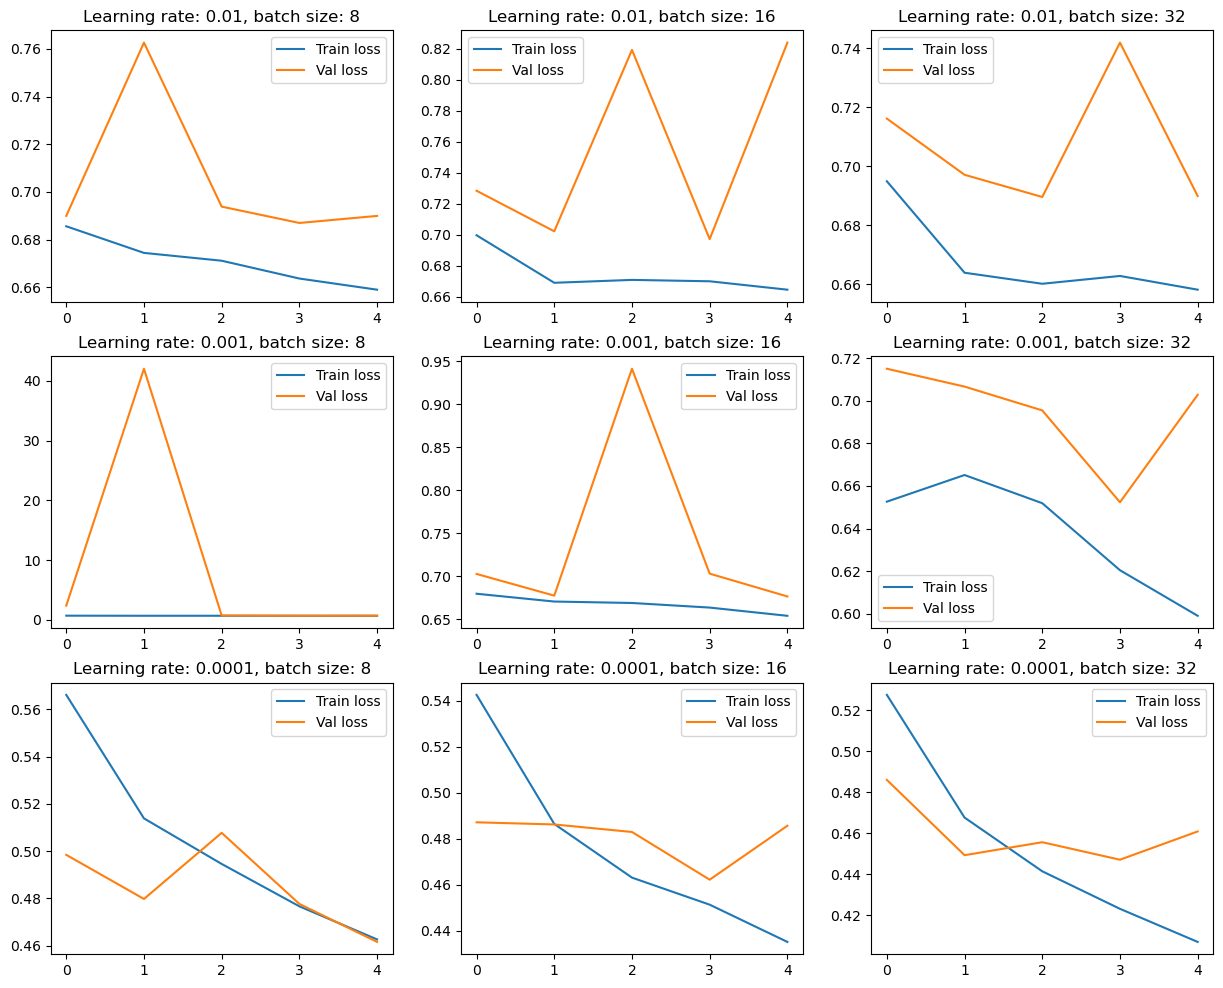

In [16]:
from matplotlib import pyplot as plt

# Plot results
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for result in results:

    row = learning_rates.index(result['lr'])
    col = batch_sizes.index(result['batch_size'])

    pd.DataFrame({
        'Train loss': result['train_losses'],
        'Val loss': result['val_losses'],
    }).plot(title=f"Learning rate: {result['lr']}, optimizer: {result['batch_size']}", ax=ax[row][col])
    ax[row][col].set_title(f"Learning rate: {result['lr']}, batch size: {result['batch_size']}")    
    


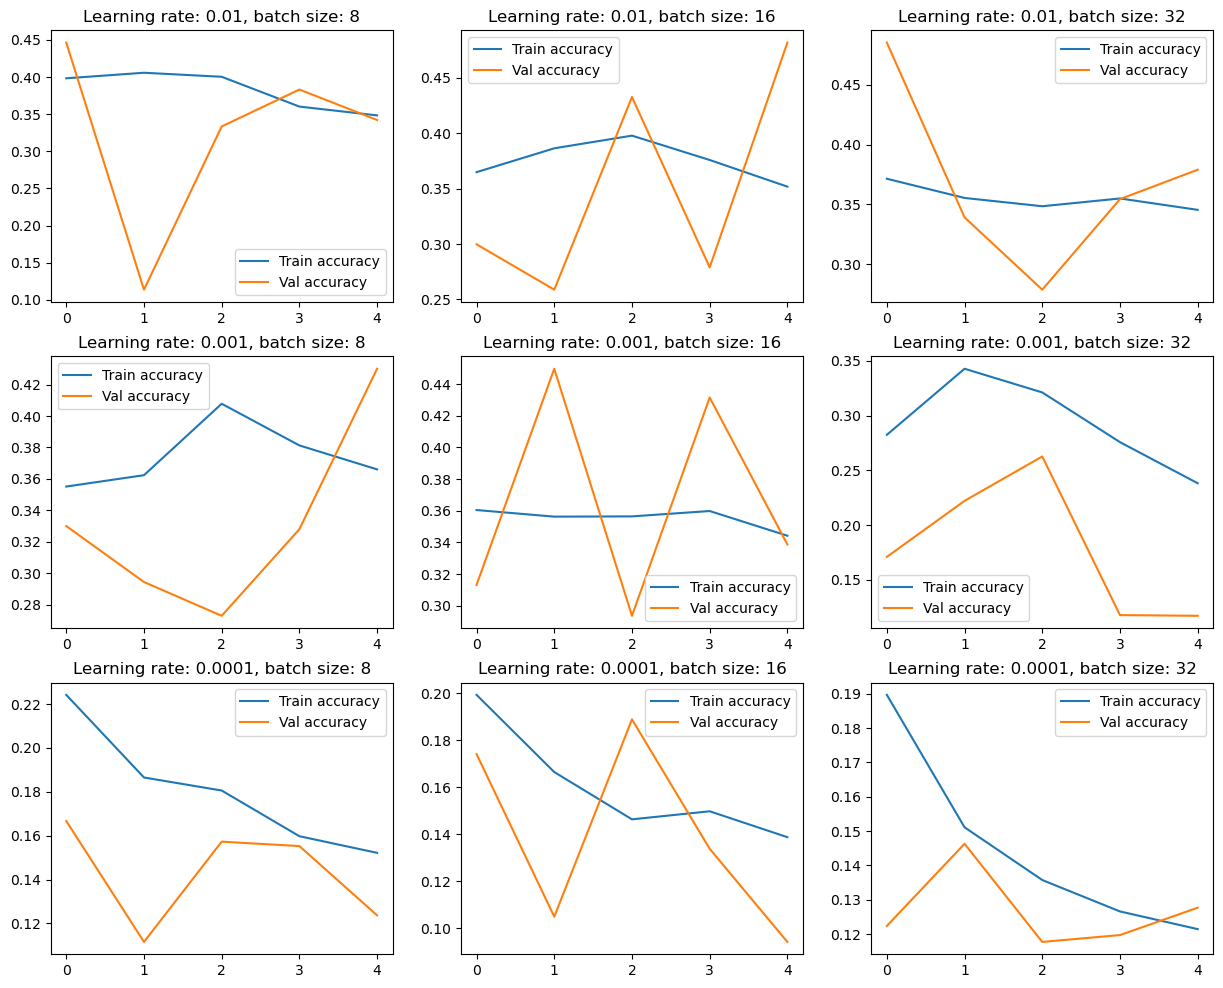

In [17]:
# Plot the accuracy
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for result in results:
    row = learning_rates.index(result['lr'])
    col = batch_sizes.index(result['batch_size'])

    pd.DataFrame({
        'Train accuracy': result['train_acc'],
        'Val accuracy': result['val_acc'],
    }).plot(title=f"Learning rate: {result['lr']}, optimizer: {result['batch_size']}", ax=ax[row][col])
    ax[row][col].set_title(f"Learning rate: {result['lr']}, batch size: {result['batch_size']}")



In [18]:
learning_rate = 0.001
batch_size = 8
epochs = 10

model = torchvision.models.densenet169(weights="DenseNet169_Weights.DEFAULT")
model.classifier = torch.nn.Linear(model.classifier.in_features, 1)
model = model.cuda()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=learning_rate)

loss_fn = torch.nn.BCEWithLogitsLoss()

train_losses, val_losses, train_acc_list, val_acc_list = train_model(model, train_loader, val_loader, loss_fn, optimizer, n_epochs=epochs)

# Plot the training and validation loss
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()



======== Epoch 1 / 10 ========
Training on training dataset...


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  Batch   100/2,357.    Elapsed: 0:00:19.
  Batch   200/2,357.    Elapsed: 0:00:37.
  Batch   300/2,357.    Elapsed: 0:00:56.
  Batch   400/2,357.    Elapsed: 0:01:14.
  Batch   500/2,357.    Elapsed: 0:01:33.
  Batch   600/2,357.    Elapsed: 0:01:51.
  Batch   700/2,357.    Elapsed: 0:02:09.
  Batch   800/2,357.    Elapsed: 0:02:28.
  Batch   900/2,357.    Elapsed: 0:02:46.
  Batch 1,000/2,357.    Elapsed: 0:03:04.
  Batch 1,100/2,357.    Elapsed: 0:03:23.
  Batch 1,200/2,357.    Elapsed: 0:03:41.
  Batch 1,300/2,357.    Elapsed: 0:04:00.
  Batch 1,400/2,357.    Elapsed: 0:04:19.
  Batch 1,500/2,357.    Elapsed: 0:04:37.
  Batch 1,600/2,357.    Elapsed: 0:04:55.
  Batch 1,700/2,357.    Elapsed: 0:05:14.
  Batch 1,800/2,357.    Elapsed: 0:05:32.
  Batch 1,900/2,357.    Elapsed: 0:05:50.
  Batch 2,000/2,357.    Elapsed: 0:06:09.
  Batch 2,100/2,357.    Elapsed: 0:06:27.
  Batch 2,200/2,357.    Elapsed: 0:06:46.
  Batch 2,300/2,357.    Elapsed: 0:07:04.
Evaluate on validation dataset...
